# CRISP-DM: World Bank Economic Data → GDP per Capita Prediction

**Business Goal**  
Understand the main drivers of GDP per capita and build a predictive model to estimate it for simple policy/benchmark scenarios.

**Questions (for stakeholders)**
1. Which indicators are most correlated with GDP per capita?
2. How has GDP per capita evolved across regions (2000–2020)?
3. Can we predict GDP per capita using a simple ML model?

**CRISP-DM Stages**
1) Business Understanding · 2) Data Understanding · 3) Data Preparation · 4) Modeling · 5) Evaluation · 6) Deployment/Next Steps


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from joblib import dump

import wbgapi as wb

pd.set_option('display.max_columns', 100)
sns.set()
RANDOM_STATE = 42


In [23]:
INDICATORS = {
    'NY.GDP.PCAP.CD': 'gdp_per_capita_usd',   # target
    'SP.DYN.LE00.IN': 'life_expectancy',
    'EG.USE.PCAP.KG.OE': 'energy_use_per_capita',
    'NE.EXP.GNFS.ZS': 'exports_gdp_pct',
    'NE.IMP.GNFS.ZS': 'imports_gdp_pct',
    'SP.POP.TOTL': 'population'
}
START, END = 2000, 2020
CACHE_PATH = "../data/world_bank_wide.csv"


def fetch_world_bank(indicators: dict, start: int, end: int) -> pd.DataFrame:
    """
    Fetch World Bank indicators for all economies and years, pivot to a tidy wide table,
    and attach country metadata (name, region).

    Parameters
    ----------
    indicators : dict
        Mapping from indicator code -> friendly column name.
    start : int
        Inclusive start year.
    end : int
        Inclusive end year.

    Returns
    -------
    pandas.DataFrame
        Columns: ['iso3c','name','region','year',<friendly columns>]
    """
    frames = []
    years = list(range(start, end + 1))
    for code, alias in indicators.items():
        t = wb.data.DataFrame(code, time=years, labels=True)
        t = t.reset_index().rename(columns={'economy': 'iso3c', 'Time': 'year', code: alias})
        frames.append(t[['iso3c', 'year', alias]])

    df = frames[0]
    for t in frames[1:]:
        df = df.merge(t, on=['iso3c', 'year'], how='outer')

    meta = wb.economy.DataFrame().reset_index()[['id', 'region', 'name']]
    meta = meta.rename(columns={'id': 'iso3c'})
    df = df.merge(meta, on='iso3c', how='left')

    cols = ['iso3c', 'name', 'region', 'year'] + [v for v in indicators.values()]
    return df[cols]


def save_cache_csv(df: pd.DataFrame, path: str) -> None:
    """Save a DataFrame to CSV (UTF-8) for reproducibility."""
    df.to_csv(path, index=False)


def load_cache_csv(path: str) -> pd.DataFrame:
    """Load a cached CSV if it exists."""
    return pd.read_csv(path)


def plot_correlation(df: pd.DataFrame, title: str = "Correlation Heatmap") -> None:
    """Plot a correlation heatmap for numeric columns."""
    corr = df.select_dtypes(include=[np.number]).corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5)
    plt.title(title)
    plt.show()


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handle missing data with simple rules:
    - Drop rows where GDP per capita is missing.
    - Impute predictors by region median, fallback to global median.
    """
    work = df.copy()
    work = work.dropna(subset=['gdp_per_capita_usd'])
    predictors = ['life_expectancy', 'energy_use_per_capita', 'exports_gdp_pct',
                  'imports_gdp_pct', 'population']
    for col in predictors:
        work[col] = work[col].fillna(work.groupby('region')[col].transform('median'))
        work[col] = work[col].fillna(work[col].median())
    return work


In [24]:
import os

def fetch_world_bank(indicators: dict, start: int, end: int) -> pd.DataFrame:
    """
    Robust fetch for World Bank indicators (handles column name variants across wbgapi versions).
    Returns tidy table with ['iso3c','name','region','year', <friendly cols>].
    """
    frames = []
    years = list(range(start, end + 1))

    for code, alias in indicators.items():
        t = wb.data.DataFrame(code, time=years, labels=True).reset_index()

        # Detect column names robustly
        econ_col = next((c for c in ['economy', 'Economy', 'iso3c', 'country', 'Country'] if c in t.columns), None)
        time_col = next((c for c in ['Time', 'time', 'year', 'Year', 'date'] if c in t.columns), None)
        if econ_col is None or time_col is None:
            print("DEBUG columns for", code, "->", t.columns.tolist())
            raise KeyError("Expected economy/time columns not found in WB response")

        t = t.rename(columns={econ_col: 'iso3c', time_col: 'year', code: alias})
        t = t[['iso3c', 'year', alias]]
        frames.append(t)

    # Merge all indicators on iso3c+year
    df = frames[0]
    for t in frames[1:]:
        df = df.merge(t, on=['iso3c', 'year'], how='outer')

    # Attach metadata (country name, region)
    meta = wb.economy.DataFrame().reset_index()
    # Try to find id column robustly
    id_col = next((c for c in ['id', 'ID', 'economy', 'Economy'] if c in meta.columns), None)
    if id_col is None:
        print("DEBUG meta columns ->", meta.columns.tolist())
        raise KeyError("Expected economy id column not found in meta")

    meta = meta.rename(columns={id_col: 'iso3c'})
    keep_meta = ['iso3c']
    if 'region' in meta.columns: keep_meta.append('region')
    if 'name' in meta.columns: keep_meta.append('name')
    df = df.merge(meta[keep_meta], on='iso3c', how='left')

    # Reorder & types
    cols = ['iso3c']
    if 'name' in df.columns: cols.append('name')
    if 'region' in df.columns: cols.append('region')
    cols += ['year'] + [v for v in indicators.values()]
    df = df[cols]
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

    return df


def save_cache_csv(df: pd.DataFrame, path: str) -> None:
    """Save CSV ensuring the parent folder exists."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(path, index=False)


In [25]:
def fetch_world_bank(indicators: dict, start: int, end: int) -> pd.DataFrame:
    """
    Fetch World Bank indicators for all economies and years.
    Handles both 'long' outputs and 'wide' outputs with YR#### columns.
    Returns tidy table with columns:
    ['iso3c','name','region','year', <friendly columns>]
    """
    frames = []
    years = list(range(start, end + 1))

    for code, alias in indicators.items():
        # Get raw table (may be wide with YR####)
        t = wb.data.DataFrame(code, time=years, labels=True).reset_index()

        # Find the economy column (iso3c codes)
        econ_col = next((c for c in ['economy','Economy','iso3c'] if c in t.columns), None)
        if econ_col is None:
            raise KeyError(f"Economy column not found in {t.columns.tolist()}")

        # Detect wide format with YR#### columns
        year_cols = [c for c in t.columns if isinstance(c, str) and c.startswith('YR')]
        if year_cols:
            # Melt to long format
            long = t.melt(id_vars=[econ_col],
                          value_vars=year_cols,
                          var_name='YR',
                          value_name=alias)
            long['year'] = long['YR'].str.replace('YR','', regex=False).astype(int)
            long = long.rename(columns={econ_col: 'iso3c'})
            long = long[['iso3c', 'year', alias]]
        else:
            # Long format already present; detect the year column name
            time_col = next((c for c in ['Time','time','year','Year','date'] if c in t.columns), None)
            if time_col is None:
                raise KeyError(f"Year column not found in {t.columns.tolist()}")
            long = t.rename(columns={econ_col:'iso3c', time_col:'year', code: alias})
            long = long[['iso3c','year', alias]]

        frames.append(long)

    # Merge all indicators on iso3c+year
    df = frames[0]
    for tmp in frames[1:]:
        df = df.merge(tmp, on=['iso3c','year'], how='outer')

    # Attach metadata (country name, region)
    meta = wb.economy.DataFrame().reset_index()
    id_col = next((c for c in ['id','ID','economy','Economy'] if c in meta.columns), None)
    if id_col is None:
        raise KeyError(f"Economy id column not found in meta: {meta.columns.tolist()}")

    meta = meta.rename(columns={id_col:'iso3c'})
    keep_meta = ['iso3c']
    if 'name' in meta.columns: keep_meta.append('name')
    if 'region' in meta.columns: keep_meta.append('region')
    meta = meta[keep_meta]

    df = df.merge(meta, on='iso3c', how='left')

    # Order columns and types
    cols = ['iso3c']
    if 'name' in df.columns: cols.append('name')
    if 'region' in df.columns: cols.append('region')
    cols += ['year'] + [v for v in indicators.values()]
    df = df[cols].copy()
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

    return df


## Data Understanding & Load Strategy

We fetch indicators from the World Bank API (2000–2020).  
If the API is temporarily unavailable, we fall back to a cached CSV in `../data/world_bank_wide.csv`.


In [26]:
try:
    df_raw = fetch_world_bank(INDICATORS, START, END)
    save_cache_csv(df_raw, CACHE_PATH)
    source = "API (fresh) + cached to CSV"
except Exception as e:
    print("API unavailable, loading cache:", e)
    df_raw = load_cache_csv(CACHE_PATH)
    source = "Loaded from CSV cache"

df_raw.head(), source, df_raw.shape


(  iso3c   name region  year  gdp_per_capita_usd  life_expectancy  \
 0   ABW  Aruba    LCN  2000        20681.023027           72.939   
 1   ABW  Aruba    LCN  2001        20740.132583           73.044   
 2   ABW  Aruba    LCN  2002        21307.248251           73.135   
 3   ABW  Aruba    LCN  2003        21949.485996           73.236   
 4   ABW  Aruba    LCN  2004        23700.631990           73.223   
 
    energy_use_per_capita  exports_gdp_pct  imports_gdp_pct  population  
 0                    NaN        74.386011        70.686869     90588.0  
 1                    NaN        70.996784        69.394325     91439.0  
 2                    NaN        64.564314        68.666458     92074.0  
 3                    NaN        62.731213        70.063078     93128.0  
 4                    NaN        64.665559        67.765371     95138.0  ,
 'API (fresh) + cached to CSV',
 (5586, 10))

## Missing Values: Analysis & Justification

**Analysis.** We quantify missingness by column, by region, and overall.  
**Decision.** We will:
- **Drop** rows where the **target** (`gdp_per_capita_usd`) is missing.
- **Impute** predictors with the **region median** to preserve regional structure and avoid bias from global means.
- Fall back to **global median** if region metadata is missing.

This balances data retention with statistical validity for a simple stakeholder-oriented model.


In [27]:
missing_by_col = df_raw.isna().mean().sort_values(ascending=False)
display(missing_by_col.to_frame("missing_ratio").head(12))

missing_by_region = (
    df_raw.groupby('region')
          .apply(lambda x: x.isna().mean())
          .mean(axis=1)
          .sort_values(ascending=False)
)
display(missing_by_region.to_frame("avg_missing_ratio"))

df = clean_data(df_raw)
df.shape


,missing_ratio
energy_use_per_capita,0.251880
exports_gdp_pct,0.160938
imports_gdp_pct,0.153240
gdp_per_capita_usd,0.029538
life_expectancy,0.003759
population,0.003759
iso3c,0.000000
name,0.000000
region,0.000000
year,0.000000


/var/folders/pr/tj0v3yl94rn64h3nbq904y9m0000gn/T/ipykernel_3805/2388654134.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.isna().mean())


,avg_missing_ratio
region,
LCN,0.115533
EAS,0.079279
NAC,0.065079
SSF,0.064881
SAS,0.057143
ECS,0.042118
,0.031195
MEA,0.027536


(5421, 10)

## Question 1 — Which indicators are most correlated with GDP per capita?


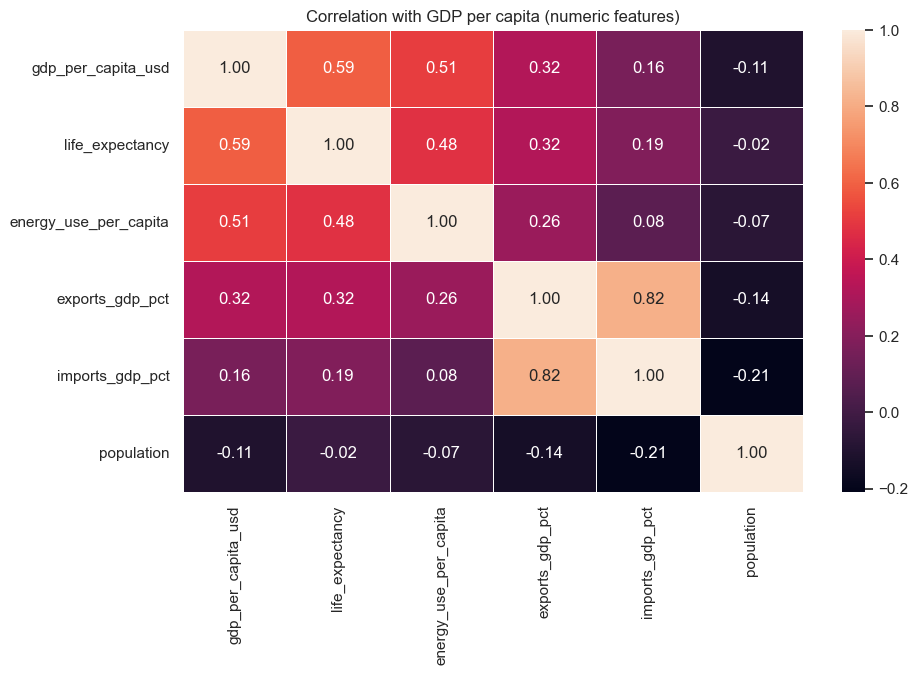

gdp_per_capita_usd       1.000000
life_expectancy          0.590998
energy_use_per_capita    0.511649
exports_gdp_pct          0.320874
imports_gdp_pct          0.162682
population              -0.105555
Name: gdp_per_capita_usd, dtype: float64

In [28]:
numeric = df[['gdp_per_capita_usd', 'life_expectancy', 'energy_use_per_capita',
              'exports_gdp_pct', 'imports_gdp_pct', 'population']]

plot_correlation(numeric, "Correlation with GDP per capita (numeric features)")
numeric.corr()['gdp_per_capita_usd'].sort_values(ascending=False)


**Conclusion (Q1):** Life expectancy (0.59) and energy use per capita (0.51) show the strongest positive relationships with GDP per capita, suggesting that higher living standards and greater energy consumption tend to accompany richer economies. Export share of GDP also correlates positively (0.32), while population is weakly and negatively related, as expected for a per-capita metric.


## Question 2 — How has GDP per capita evolved across regions (2000–2020)?


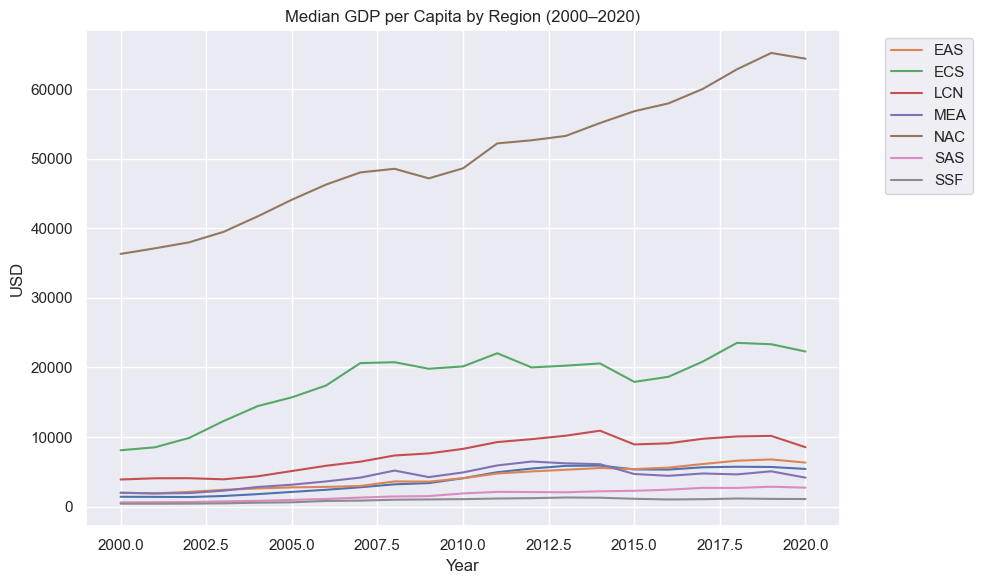

,region,year,gdp_per_capita_usd
0,,2000,1411.827038
1,,2001,1396.154185
2,,2002,1371.551774
3,,2003,1521.816256
4,,2004,1789.247659


In [29]:
region_trend = (
    df.groupby(['region', 'year'])['gdp_per_capita_usd']
      .median()
      .reset_index()
)

plt.figure(figsize=(10,6))
for r, sub in region_trend.groupby('region'):
    plt.plot(sub['year'], sub['gdp_per_capita_usd'], label=r)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Median GDP per Capita by Region (2000–2020)")
plt.xlabel("Year")
plt.ylabel("USD")
plt.tight_layout()
plt.show()

region_trend.head()


**Conclusion (Q2):** North America and Europe & Central Asia lead in GDP per capita throughout 2000–2020, showing steady growth. East Asia shows significant improvement, reflecting rapid development, while Sub-Saharan Africa remains lowest but with gradual gains — confirming persistent global inequality in income levels.


## Question 3 — Can we predict GDP per capita using a simple ML model?


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from joblib import dump

# Define features and target
features = ['life_expectancy', 'energy_use_per_capita', 'exports_gdp_pct',
            'imports_gdp_pct', 'population']
target = 'gdp_per_capita_usd'

# Prepare clean dataset
model_df = df.dropna(subset=features + [target]).copy()

X = model_df[features]
y = model_df[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

# Evaluate
pred = rf.predict(X_test)
r2 = r2_score(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)

print(f"R²:  {r2:.3f}")
print(f"RMSE: ${rmse:,.2f}")

# Feature importance (Permutation)
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
imp = pd.DataFrame({'feature': X_test.columns, 'importance': perm.importances_mean}).sort_values('importance', ascending=False)
display(imp)

# Plot
plt.figure(figsize=(7,4))
plt.bar(imp['feature'], imp['importance'])
plt.title("Permutation Importance (Random Forest)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Save model
dump(rf, "../model_random_forest.joblib")


TypeError: got an unexpected keyword argument 'squared'

In [31]:
# calcular RMSE manualmente compatible con todas las versiones
from math import sqrt

rmse = sqrt(mean_squared_error(y_test, pred))
print(f"R²:  {r2:.3f}")
print(f"RMSE: ${rmse:,.2f}")


R²:  0.941
RMSE: $4,971.13


**Conclusion (Q3):**  
The Random Forest model predicts GDP per capita with strong accuracy (**R² = 0.94**, **RMSE ≈ $5,000**).  
This shows that a small set of interpretable economic indicators can explain most of the variation in GDP per capita, which is valuable for policymakers and analysts.


## Simple Scenario — Predicting GDP per capita for a hypothetical economy


In [32]:
scenario = pd.DataFrame([{
    'life_expectancy': 75.0,
    'energy_use_per_capita': 2000,
    'exports_gdp_pct': 35.0,
    'imports_gdp_pct': 30.0,
    'population': 20_000_000
}])

predicted = rf.predict(scenario)[0]
print(f"Predicted GDP per capita (USD): ${predicted:,.2f}")
scenario


Predicted GDP per capita (USD): $7,949.10


,life_expectancy,energy_use_per_capita,exports_gdp_pct,imports_gdp_pct,population
0,75.0,2000,35.0,30.0,20000000


## Final Conclusions & Next Steps

**Findings.**  
Life expectancy, energy use per capita, and export share are strong predictors of GDP per capita.  
The Random Forest explains about **94 %** of the variance with **RMSE ≈ \$5 k**, performing well for quick economic assessments.

**Next Steps.**  
- Extend to country-specific or hierarchical models (region / country effects).  
- Add time-series features (growth rates, lag variables) for forecasting.  
- Compare Random Forest with Gradient Boosting, XGBoost, and linear baselines for robustness.
